## Sentiment Analysis on Open Yelp Dataset Reviews

###### Artificial Intelligence Project 2020/2021

This is the notebook made by Mario Sessa for the project of Artificial Intelligence 2020/2021 on Yelp Sentiment Analysis with binary classification. The official documentation is in the same project directory with the function to explain in a theoretical way decisions taken during the project development. The entire project is based on the model taken from references papers, machine learning framework used is Tensorflow 2.6.0. Package dependencies will be deploy on a file <i>requirements.txt</i> and use explain in the <i>README.md</i> for possible dependencies problem.

### Load Dataset

Project dataset is the Academic Yelp Dataset, available on <a href="https://www.yelp.com/dataset">https://www.yelp.com/dataset</a>. This dataset has a huge dimensions for the reviews table, so we will load data using chunks method and data segmentation using data types given by the <a href="https://www.yelp.com/dataset/documentation/main" >yelp dataset documentations.</a>

In this notebook we will: <br>
<a>1. Load dataset</a><br>
<a>2. Data analysis</a><br>
<a>3. Pre-processing</a><br>
<a>4. Multinomial Naive Bayes model</a><br>
<a>5. Deep learning on biLSTM and LSTM models</a><br>
<a>6. BERT model</a><br>
<a>7. Store models in memory</a><br>
<a>8. Results and conclusion</a><br>

During every phase, we describe some procedures which we follows to have a clean vision of what we did in the project.

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

rtypes = {  "stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32,
           }

chunk_size = 10000
path = './data/yelp_academic_dataset_review.json'
def read_chunk(path, rtypes, chunk_size):
    
    review = pd.read_json(path, lines=True,
                      orient="records",
                      dtype=rtypes,
                      chunksize=chunk_size)
    chunk_list = []

    for chunk_review in review:
        chunk_list.append(chunk_review)
    
    df = pd.concat(chunk_list, ignore_index=True, axis=0)
    return df

df = read_chunk(path, rtypes, chunk_size)
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


### Data Analysis

In this section we will discuss shortly properties of the dataset which can be useful for one of more models. Apparently, we need to analyze the domain of each column to obtain main statistics and define how to proceed in the next steps.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as lines
%matplotlib inline

In [3]:
df['stars'] = df['stars'].astype(int)
df['texts_length']  = df['text'].str.len()
np.asarray(df['stars'])

array([4, 4, 5, ..., 5, 2, 5])

##### Stars

Stars analysis is based on the values and types distribution and possible correlation with other features. According with the official documentation, the domain of stars is a value between 1 (worst) to 5 (best). Generally, people have different evaluation metrics which may make our problem harder to classify. The aim of the analysis is to define the 'next steps' procedures in according to obtained results.

In [4]:
bin_df = pd.DataFrame()
bin_df['stars'] = [0 if star <= 3 else 1 for star in df['stars']]
    
def stars_distribution_plot(stars, title, plot_type):
    plt.figure(figsize=(4,4))
    if plot_type == 1:
        sns.distplot(stars)
    else:
        stars.value_counts().plot.bar(color='blue')
    plt.title(title)

def stars_length_plot(dataframe):
    graph = sns.FacetGrid(data = dataframe, col = 'stars')
    graph.map(plt.hist, 'texts_length', bins=50, color='blue')
    
def stars_correlation_heatmap(df):
    sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")


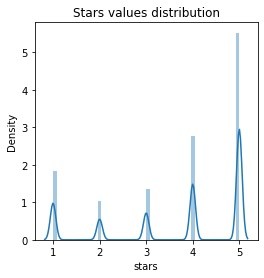

In [5]:
stars_distribution_plot(df.stars, 'Stars values distribution',1)

As we can see from the below plot, the distribution of stars value are not in equal number. This should be a problem during model training because we need to flat the distribution for a correct balanced features analysis.

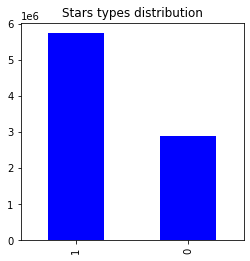

In [6]:
stars_distribution_plot(bin_df.stars, 'Stars types distribution', 0)

As the unbalanced values distribution, the well dependent problem is propagated to reviews types too.

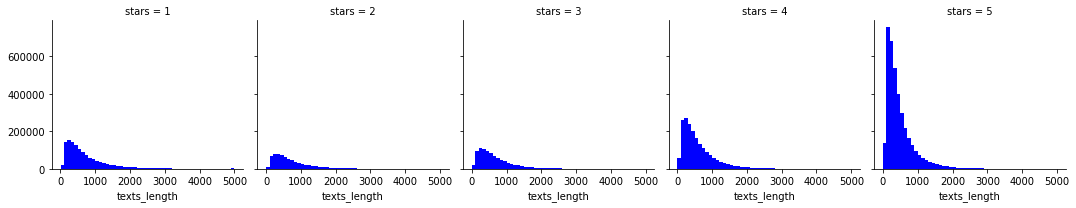

In [7]:
stars_length_plot(df)

Text length distribution across reviews with different stars values is almost the same. So we don't have a direct connection between the text length and the stars value. According to the previous data, we can display a correlation heatmap to estabilish possible correlations with other types of features.

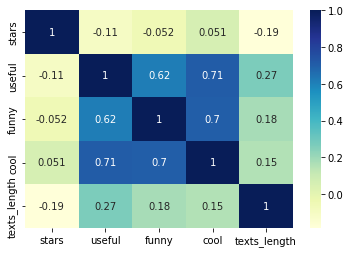

In [8]:
stars_correlation_heatmap(df)

There is not some correlations between text length or stars and the secondary features. Generally, when a customers or a client try to do a review about a service or a place, they can evaluate in according on how cool a place it, if the experience he or she did was funny or if the service is useful. Otherwise, inside the yelp reviews, these parametes were ignored by reviews creators, so we will not consider them in the model training.

#### Texts

In [9]:
from wordcloud import WordCloud
from nltk.probability import FreqDist
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS
from nltk.tokenize import word_tokenize

In the text analysis, our aim is to define properties which can be useful for the text manipulation before the model training and modify them in according to the model approach used. For instance, if we want to use a deep neural network, we need to encode a series of words or sentences and compute them in deep and slow layers (expecially for LSTM or biLSTM usually used for natural language processing which are sequential models)

In [10]:
def high_words_frequency_plot(df):
    input_texts = c_low(df)
    word_tokens = word_tokenize(input_texts)
    tokens = list()
    for word in word_tokens:
        if word.isalpha() and word not in STOPWORDS:
            tokens.append(word)
    token_dist = FreqDist(tokens)
    dist = pd.DataFrame(token_dist.most_common(10),columns=['Word', 'Frequency'])
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_axes([0,0,1,1])
    x = dist['Word']
    y = dist['Frequency']
    ax.bar(x,y)
    plt.title('Terms Frequency')
    plt.show()
    return dist


def wordcloud_plot(df):
    subset = df[:int(len(df)/100)]
    input_text = c_low(subset['text'])
    wordCloud = WordCloud(background_color='white', stopwords=STOPWORDS).generate(input_text)
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
def c_low(texts):
    return ' '.join(texts).lower()

def count_words(texts):
    map_list = list()
    map_terms = dict()
    for text in texts:
        word_tokens = word_tokenize(text)
        for word in word_tokens:
            if word not in map_terms:
                map_terms[word] = 1
        map_list.append(len(map_terms))
        map_terms = dict()
    return map_list

    
def stopwords_counts(texts):
    map_sw = dict()
    map_list = list()
    for text in texts:
        word_tokens = word_tokenize(text)
        for word in word_tokens:
            if word in STOPWORDS:
                map_sw[word] = 1
        map_list.append(len(map_sw))
        map_sw = dict()
    return map_list


In [11]:
%%time
limit = 100000
df_plot = pd.DataFrame(columns=['terms_counts', 'stopwords_counts'])
df_plot['terms_counts'] = count_words(df['text'][:limit])
df_plot['stopwords_counts'] = stopwords_counts(df['text'][:limit])

CPU times: user 2min 26s, sys: 330 ms, total: 2min 27s
Wall time: 2min 27s


The mean words cardinality in yelp reviews is: 78.
The mean stopwords cardinality in yelp reviews is: 28


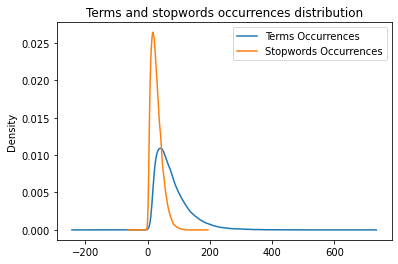

In [12]:
df_occurrences = pd.DataFrame(columns=['Terms Occurrences', 'Stopwords Occurrences'])
df_occurrences['Terms Occurrences'] = df_plot['terms_counts']
df_occurrences['Stopwords Occurrences'] = df_plot['stopwords_counts']
df_occurrences.plot(kind="kde")
plt.title('Terms and stopwords occurrences distribution')
print(f"The mean words cardinality in yelp reviews is: {int(df_plot['terms_counts'].mean())}.")
print(f"The mean stopwords cardinality in yelp reviews is: {int(df_plot['stopwords_counts'].mean())}")

For views semplification we taken only the first 100.000 values. The mean value is lower than 100, so we need to consider at least 100 words in the text of each review. The number of words per reviews will be reduce for some long-computational models thanks to the stopwords removing in a pre-processing phase. 

The stopwords ratio for each yelp reviews is: 36%


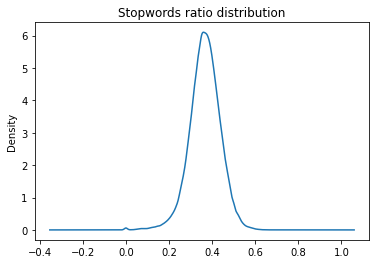

In [13]:
stopwords = df_plot['stopwords_counts']
terms = df_plot['terms_counts']
df_plot['stopwords_ratio'] = stopwords / terms
df_plot['stopwords_ratio'].plot(kind='kde')
plt.title('Stopwords ratio distribution')
print(f"The stopwords ratio for each yelp reviews is: {int(df_plot['stopwords_ratio'].mean()*100)}%")

The density on the stopwords ratio is around 36%, so if we reduce the texts content removing these kind of terms we will drastically increase training time on complex or slow models like deep neural network. However, the level of precision can be reduced for a less terms variance in other kind of model which can consider the dependency treebanks.

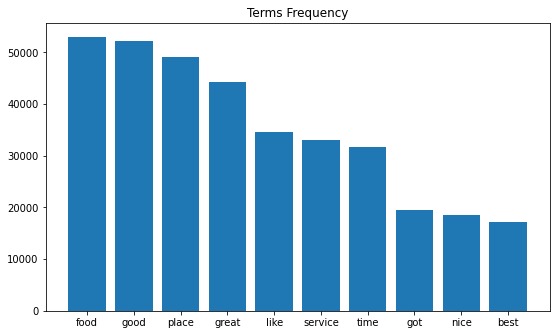

In [14]:
dist = high_words_frequency_plot(df['text'][:limit])

As we can see in the wordcloud or in the terms frequency plot upside, most used words are references to conceptual terms which can guarantee a correct binary classification. As we saw before, most common terms would be positive for the huge difference between negative and positive terms.

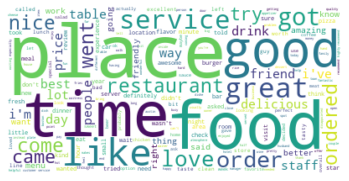

In [15]:
wordcloud_plot(df)

Wordcloud is a visible classification of symbols and words. In our case, it is good to show us how the common terms are distributed inside reviews text.

### Pre-processing

This phase consists in:
1. Clean dataset from unused features
2. Transform stars domain in a binary one
3. Balancing dataset and return a balanced subset in output
4. Reduce texts in lowercase
5. PoS Tagging and lemmatize texts
6. Remove stopwords and punctuation marks

Other ad-hoc pre-processing operations are done before the models trainings.

##### Data clenaning

In [16]:
df_balanced = df.drop(['review_id', 'user_id', 'business_id', 'useful', 'funny', 'cool','texts_length', 'date'], axis=1)
df_balanced['text'].dropna(inplace=True)
print(f'{df_balanced.info()}')
print('----------------------')
print(f'{df_balanced.head()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8635403 entries, 0 to 8635402
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   stars   int64 
 1   text    object
dtypes: int64(1), object(1)
memory usage: 131.8+ MB
None
----------------------
   stars                                               text
0      4  Apparently Prides Osteria had a rough summer a...
1      4  This store is pretty good. Not as great as Wal...
2      5  I called WVM on the recommendation of a couple...
3      2  I've stayed at many Marriott and Renaissance M...
4      4  The food is always great here. The service fro...


#### Stars polarization and dataset balancing

In [17]:
from collections import Counter

def polarize_stars(stars):
    return [0 if star <= 3 else 1 for star in stars]

def balance_dataframe(limit):
    balancedTexts = [] 
    balancedLabels = [] 
    negPosCounts = [0, 0] 
    for i in range(0,len(texts)):
        polarity = stars[i]
        if negPosCounts[polarity] < limit: 
            balancedTexts.append(texts[i])
            balancedLabels.append(stars[i])
            negPosCounts[polarity] += 1
    df_balanced = pd.DataFrame()
    df_balanced['text'] = balancedTexts
    df_balanced['labels'] = balancedLabels
    return df_balanced


In [18]:
texts =  df['text']
stars = polarize_stars(df['stars'])
df_balanced = balance_dataframe(200000)
print(f'Length of the dataframe  : {len(df_balanced)}')
print(f'Mean star values         : {df_balanced.labels.mean()}')

counter = Counter(df_balanced['labels'])
print(f'Positive reviews         : {counter[1]}')
print(f'Positive reviews         : {counter[0]}')

Length of the dataframe  : 400000
Mean star values         : 0.5
Positive reviews         : 200000
Positive reviews         : 200000


#### Reduce texts in lowercase

In [19]:
def lower_case(df_text):
    return [review_text.lower() for review_text in df_text]

df_balanced['text'] = lower_case(df_balanced['text'])

Dataset length has 400.000 rows with no unused features; a label identify the star value polarization which is 1 if the stars value is great than 3 and 0 otherwise and the text is in lowercase. These binary values can represent the positive and negative label for the binary classification in the sentiment analysis process did in the next phase. The next steps in the current pre-processig procedure will include the removes of the stopwords and the lemmatization of texts. Not every model needs the remove stopwords because they should be useful for context analysis if a trained model consider semantic features. So we save a balanced dataset state before the stopword removing operation.

In [20]:
_df_balanced = df_balanced

#### PoS Tagging and Lemmatization

In [21]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

It is refered to the analysis of text, define PoS tagging and doing generation of lemmas. The lemmatization involves an onerous procedure on the balanced dataset. Particularly, we will associate a semantic tag to each word in order to differentiate which type of term is being analyzed and, according to the semantic class to which it belongs, carry out an ad-hoc lemmatization in order to obtain the correct normalized form.

In [22]:
%%time

lemmatizer = WordNetLemmatizer()

def word_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

    
def lemmatize(texts):
    df_texts = []
    for text in texts:
        word_tagged = nltk.pos_tag(nltk.word_tokenize(text))
        map_word_tag = list(map(lambda x: (x[0], word_tagger(x[1])), word_tagged))
        lemmatized_text = []
        for word, tag in map_word_tag:
            if tag is None:
                lemmatized_text.append(word)
            else:
                lemmatized_text.append(lemmatizer.lemmatize(word, tag))
        lemmatized_text = " ".join(lemmatized_text)
        df_texts.append(lemmatized_text)
    return df_texts




df_balanced['text'] = lemmatize( df_balanced['text'])
print(f"It is the not lemmatized text: {_df_balanced['text'][0]}")
print(f"It is the lemmatized text    : {df_balanced['text'][0]}")

It is the not lemmatized text: apparently pride osteria have a rough summer as evidence by the almost empty dining room at 6:30 on a friday night . however new blood in the kitchen seem to have revitalize the food from other customer recent visit . waitstaff be warm but unobtrusive . by 8 pm or so when we leave the bar be full and the dining room be much more lively than it have be . perhaps beverly resident prefer a later seating . after read the mixed review of late i be a little tentative over our choice but luckily there be nothing to worry about in the food department . we start with the fried dough , burrata and prosciutto which be all lovely . then although they do n't offer half portion of pasta we each order the entree size and split them . we choose the tagliatelle bolognese and a four cheese fill pasta in a creamy sauce with bacon , asparagus and grana frita . both be very good . we split a secondo which be the special berkshire pork secreto , which be describe as a pork ski

In [23]:
__df_balanced = df_balanced['text']

#### Removing stopwords

In [24]:
def rm_sw_and_punct(texts_list):
    
    # removing stopwords
    tmp_texts = []
    for text in texts_list:
        tmp_texts.append(remove_stopwords(text))

    texts_list = tmp_texts

    # removing not alfanumeric characters
    tmp_texts = []
    for text in texts_list:
        tmp_texts.append(''.join(ch for ch in text if ch.isalnum() or ch == ' '))

    texts_list = tmp_texts
    return texts_list

df_balanced['text'] = rm_sw_and_punct(df_balanced['text'])


The result of the pre-processing it's a cleaned text with alphanumeric characters and lemmatized words, this is the minimization of the not-conceptual variation of a text form. In other words, we can define now a vectorization which use an encoded algorithm to transform terms in a sentence in a sequence of integers based on different metrics. As we can see in the next steps, not every method will use the text input using the conceptual reduction (stopwords removing and lemmatized text). In conclusion, we don't tokenize the elements right now but in the next step; that's because are particularly interested in the optimization of models; so we can do an ad-hoc vectorization or encoded tecniques which is good for the model that use it.

In [25]:
import tensorflow as tf
import os
print(tf.sysconfig.get_compile_flags())
print(tf.__version__)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

['-I/usr/local/lib/python3.9/site-packages/tensorflow/include', '-D_GLIBCXX_USE_CXX11_ABI=0', '-DEIGEN_MAX_ALIGN_BYTES=64']
2.6.0


### Naive Bayes Classification

In [26]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

#### Count vectorizer

Counting vectorizer convert a collection of texts like our reviews in a matrix of token counts. If we want to manage it in a good way for split the dataset in training and testig set. We need to use a panda dataframe which includes for each column a token and for each row a series of counting values which represent the occurrences of tokens for each text in the dataset.

In [27]:
vect = CountVectorizer(max_features=300)
vect.fit(df_balanced.text)
Xc = vect.transform(df_balanced.text)
Xc_df = pd.DataFrame(Xc.toarray(), columns=vect.get_feature_names())
yc = df_balanced.labels
Xc = Xc_df
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.3, random_state=42, stratify=yc)

In [28]:
print(f" Text: {df_balanced.text[0]}")
print(f" Occurrences of table:{Xc_df['table'][0]}")

 Text: apparently pride osteria rough summer evidence dining room 630 friday night  new blood kitchen revitalize food customer recent visit  waitstaff warm unobtrusive  8 pm leave bar dining room lively  beverly resident prefer later seating  read mixed review late little tentative choice luckily worry food department  start fried dough  burrata prosciutto lovely  nt offer half portion pasta order entree size split  choose tagliatelle bolognese cheese pasta creamy sauce bacon  asparagus grana frita  good  split secondo special berkshire pork secreto  pork skirt steak garlic potato purée romanesco broccoli  incorrectly romanesco sauce   table receive bread meal reason  management capable tenant apartment begin play basketball intervene comped table dessert  order apple dumpling gelato tasty  portion huge particularly like prefer order course  order meal leave hungry depend appetite  din room young crowd bar definitely 40 set  recommend naysayer return improvement personally nt know glor

#### TF-IDF vectorizer

In [29]:
vect = TfidfVectorizer(max_features=300)
vect.fit(df_balanced.text)
Xf = vect.transform(df_balanced.text)
Xf_df = pd.DataFrame(Xf.toarray(), columns=vect.get_feature_names())
yf = df_balanced.labels
Xf = Xf_df
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.3, random_state=42, stratify=yf)

In [30]:
print(f" Text: {df_balanced.text[0]}")
print(f" Tf-idf of table:{Xf_df['table'][0]}")

 Text: apparently pride osteria rough summer evidence dining room 630 friday night  new blood kitchen revitalize food customer recent visit  waitstaff warm unobtrusive  8 pm leave bar dining room lively  beverly resident prefer later seating  read mixed review late little tentative choice luckily worry food department  start fried dough  burrata prosciutto lovely  nt offer half portion pasta order entree size split  choose tagliatelle bolognese cheese pasta creamy sauce bacon  asparagus grana frita  good  split secondo special berkshire pork secreto  pork skirt steak garlic potato purée romanesco broccoli  incorrectly romanesco sauce   table receive bread meal reason  management capable tenant apartment begin play basketball intervene comped table dessert  order apple dumpling gelato tasty  portion huge particularly like prefer order course  order meal leave hungry depend appetite  din room young crowd bar definitely 40 set  recommend naysayer return improvement personally nt know glor

#### Logistic Regression

Logistic regression uses an equation as the representation, very much like linear regression.

Input values $  x $ are combined linearly using weights or coefficient values to predict an output value $ y $. A key difference from linear regression is that the output value being modeled is a binary values (0 or 1) rather than a numeric value.

Below is an example logistic regression equation:

$ y = e^{(\beta_{0} + \beta_{1}*x)} / (1 + e^{(\beta_{0} + \beta_{1}*x)}) $

Where y is the predicted output, $\beta_{0}$ is the bias or intercept term and $\beta_{1}$ is the coefficient for the single input value $ x $. Each column in your input data has an associated $\beta$ coefficient (a constant real value) that must be learned from your training data.

The actual representation of the model that we would store in memory or in a file are the coefficients in the equation.

In [31]:
from sklearn.linear_model import LogisticRegression
pre_time = time.time()
log_reg = LogisticRegression().fit(Xc_train, yc_train)
y_pred_lg = log_reg.predict(Xc_test)
post_time = time.time()
print("Logistic Regression on count vectorizer")
print("---------------------------------------")
print(f"Accuracy: {round(accuracy_score(yc_test ,y_pred_lg),4)}")
print(f"F1 Score: {round(f1_score(yc_test, y_pred_lg),4)}")
print(f"Time: {round((post_time - pre_time), 4)} s\n\n")

pre_time = time.time()
log_reg = LogisticRegression().fit(Xf_train, yf_train)
y_pred_lg = log_reg.predict(Xf_test)
post_time = time.time()
print("Logistic Regression on count vectorizer")
print("---------------------------------------")
print(f"Accuracy: {round(accuracy_score(yf_test ,y_pred_lg),4)}")
print(f"F1 Score: {round(f1_score(yf_test, y_pred_lg),4)}")
print(f"Time: {round((post_time - pre_time), 4)} s")

Logistic Regression on count vectorizer
---------------------------------------
Accuracy: 0.8235
F1 Score: 0.8244
Time: 8.4903 s


Logistic Regression on count vectorizer
---------------------------------------
Accuracy: 0.8239
F1 Score: 0.8228
Time: 5.4168 s


#### Naive Bayes

MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice.

The distribution is parametrized by vector $\theta_{y} = (\theta_{y1}, ..., \theta_{yn}) $ which defines the class type $ y $ with $ n $ features depending on the size of vocabulary. 

Given $ \theta_{yi} $ as the probability $ P(x_{i} | y) $ of feature $ i $ appearing in a sample belonging to class $ y $, we can estimate $ \theta{y} $ vector by a smoothed version of maximum likelihood as frequency counting or tf-idf parameter.

The classification aim is to define the probability to have a success assignment of a series of words $ x_{1},...,x_{n} $ to a class $ y $. In other words, we want to calculate:


$ ~{y} = argmax_{y} P(y)\prod_{i=1}^{n}P(x_{i} | y) $

$ argmax $ identify the class $ y $ which gives the max value of $ P(y) $

In [32]:
from sklearn.naive_bayes import MultinomialNB

pre_time = time.time()
nb_classifier = MultinomialNB()
nb_classifier.fit(Xf_train, yf_train)
yf_pred = nb_classifier.predict(Xf_test)
post_time = time.time()
print("Naive Bayes on tf-idf vectorizer")
print("--------------------------------")
print(f"Accuracy: {round(accuracy_score(yf_test ,yf_pred),4)}")
print(f"F1 Score: {round(f1_score(yf_test, yf_pred),4)}")
print(f"Time: {round((post_time - pre_time), 4)} s\n\n")

pre_time = time.time()
nb_classifier = MultinomialNB()
nb_classifier.fit(Xc_train, yc_train)
yc_pred = nb_classifier.predict(Xc_test)
post_time = time.time()
print("Naive Bayes on count vectorizer")
print("--------------------------------")
print(f"Accuracy: {round(accuracy_score(yc_test ,yc_pred),4)}")
print(f"F1 Score: {round(f1_score(yc_test, yc_pred),4)}")
print(f"Time: {round((post_time - pre_time), 4)} s")

Naive Bayes on tf-idf vectorizer
--------------------------------
Accuracy: 0.7983
F1 Score: 0.8005
Time: 0.2658 s


Naive Bayes on count vectorizer
--------------------------------
Accuracy: 0.7902
F1 Score: 0.8005
Time: 2.2106 s


### Deep learning on LSTM models

In [131]:
from sklearn.metrics import f1_score
from tensorflow import keras

Deep learning approaches will use some layers tecniques based on the computation and learning on texts dataset as a numerical representation. 
To do that, we have in input the series of the texts and the respective label to be processed.

In [41]:
df_balanced.head()

,text,labels
0,apparently pride osteria rough summer evidence...,1
1,store pretty good great walmart preferred m...,1
2,wvm recommendation couple friend use past thin...,1
3,ve stay marriott renaissance marriott s huge d...,0
4,food great service manager staff super draw ...,1


#### Callbacks and additional metrics

In [154]:
es_loss_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=2, verbose=0)

#### Dataset splitting

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['text'], df_balanced['labels'], 
                               test_size = 0.33, 
                               shuffle=True, 
                               random_state = 42)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=1) 

#### Making vocabulary

In [38]:
def count_words(texts):
    map_terms = dict()
    for text in texts:
        for word in text:
            if word not in map_terms:
                map_terms[word] = 1
    return len(map_terms)

count = count_words(df_balanced['text'])
print(f'There are {count} different words') 

There are 2177 different words


In [46]:
vocab_size = count_words(df_balanced['text'])
encoder = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size)
encoder.adapt(df_balanced['text'])

#### Making model

The proposed model is the classic `Sequential` one, which has a initial encoder given by our `TextVectorizer` which transforms a sequence of words in a sequence of numerical values according to the deep learning procedures. On the next, there is an `Embedding` layer which has an input dimension equals to the sequence of word indexes and has a sequences of trainable vectors as output. We put the mask_zero to handle varying of the sequence length. Using `Bidirectional` will run our inputs in two ways, one from past to future and one from future to past and what differs this approach from unidirectional is that in the LSTM that runs backwards you preserve information from the future and using the two hidden states combined you are able in any point in time to preserve information from both past and future. In other words, we can propagate the input in forwards and backwards directions, combine the outputs for each sentence term and train informations. Finally, we have `Dense` layers which takes values of the encoded word vector and calculte the respective output to show in the prediction. We have used te binary cross-entropy which calculate the loss distribution as a differences between the true labels distibution and the predicted one. Furthermore, we used the Adam optimizers which is considered the best optimizer for the gradient descent estimation.

In [143]:
def bilstm_model():
    model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
    return model
model = bilstm_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_6 (TextVe (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 64)          139328    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 213,697
Trainable params: 213,697
Non-trainable params: 0
_________________________________________________________________


#### Training Phase

In [62]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    validation_steps=30, 
                    callbacks = [es_loss_callback])

Epoch 1/10
7538/7538 [==============================] - 955s 126ms/step - loss: 0.3386 - accuracy: 0.8416 - val_loss: 0.3059 - val_accuracy: 0.8628
Epoch 2/10
7538/7538 [==============================] - 1016s 135ms/step - loss: 0.2986 - accuracy: 0.8636 - val_loss: 0.2982 - val_accuracy: 0.8604
Epoch 3/10
7538/7538 [==============================] - 1003s 133ms/step - loss: 0.2899 - accuracy: 0.8666 - val_loss: 0.2937 - val_accuracy: 0.8700
Epoch 4/10
7538/7538 [==============================] - 1010s 134ms/step - loss: 0.2828 - accuracy: 0.8691 - val_loss: 0.2930 - val_accuracy: 0.8686
Epoch 5/10
7538/7538 [==============================] - 1022s 136ms/step - loss: 0.2773 - accuracy: 0.8722 - val_loss: 0.2947 - val_accuracy: 0.8626
Epoch 6/10
7538/7538 [==============================] - 1038s 138ms/step - loss: 0.2730 - accuracy: 0.8744 - val_loss: 0.2898 - val_accuracy: 0.8661
Epoch 7/10
7538/7538 [==============================] - 1026s 136ms/step - loss: 0.2688 - accuracy: 0.8763 

In [96]:
test_loss, test_acc = model.evaluate(X_test, y_test)

4125/4125 [==============================] - 86s 21ms/step - loss: 0.2896 - accuracy: 0.8686


In [139]:
def prediction_score(pred):
    results = []
    for x in pred:
        if x > 0: 
            x = 1 
        else:
            x = 0
        results.append(x)
    return results

In [142]:
pred = model.predict(X_test)
print("Deep Neural Network using biLSTM")
print("--------------------------------")
print(f"Accuracy : {round(test_acc,4)}")
print(f"Loss     : {round(test_loss,4)}")
print(f"F1 Score : {round(f1_score(list(y_test),prediction_score(pred)),4)}")

Deep Neural Network using biLSTM
--------------------------------
Accuracy : 0.8686
Loss     : 0.2896
F1 Score : 0.8766


#### Results

(0.0, 0.3426646083593369)

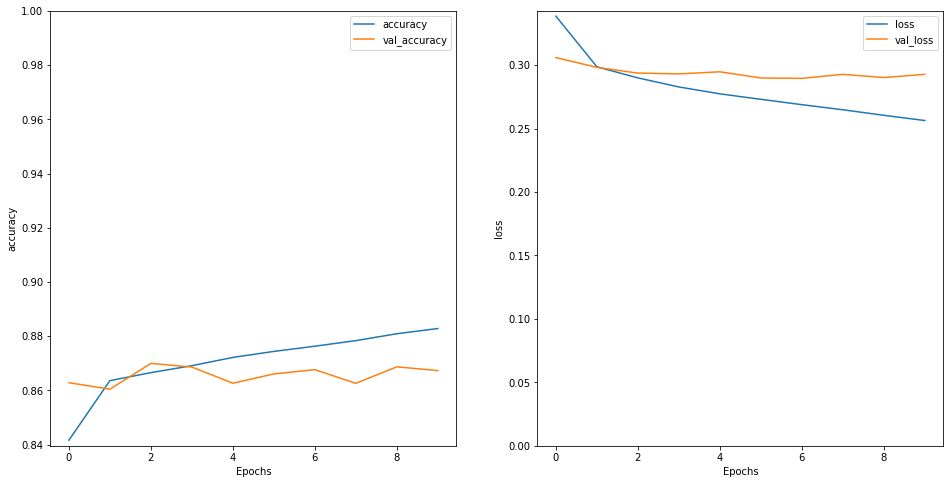

In [129]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Obtained the model, we can see the results during the training phase. Training accuracy was increasing slowly, meanwhile validation accuracy has a mean value around 86%. About the loss value, training loss was decreasing during the epochs successions, meanwhile the validation loss is at least 20%, we put only the 10% of the training set as a validation set, if we will change the training and validation ratio, model may obtain better results.

#### Model Variation

Using the same encoding, we can build a different recurrent neural network with more layers. In our case, we will choose a convulational neural network which takes the embedding vector from the `Embedding` structured as the previous model. Convolutional neural network is formed by  a `Conv1D` layer; the aim of this component is to extract features from a group of input embedding words vectors. Whereupon, we can use a `GlobalMaxPooling1D` to aggregate convolutional output and reduce the side of the input vectors. After that, we can use two `Bidirectional` lstm layers where the first one has `true_sequences` at `True` where each timestep result is given to output, the second layer is the same of the previous one. Finally, we have last `Dense` layers with a `Dropout` on 0.3 for regularization. Loss function and optimizer are the same of the previous model.

In [159]:
def conv_bilstm_model():
    model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4), # 64 x 0.4 = 8/5 _= 
    tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
    
    return model
model = conv_bilstm_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_6 (TextVe (None, None)              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, None, 64)          139328    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 128)         65664     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 128)         98816     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_20 (Dense)             (None, 64)              

In [160]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    validation_steps=30, 
                    callbacks = [es_loss_callback])

Epoch 1/10
7538/7538 [==============================] - 360s 47ms/step - loss: 0.3562 - accuracy: 0.8316 - val_loss: 0.3073 - val_accuracy: 0.8557
Epoch 2/10
7538/7538 [==============================] - 355s 47ms/step - loss: 0.3026 - accuracy: 0.8649 - val_loss: 0.2944 - val_accuracy: 0.8695
Epoch 3/10
7538/7538 [==============================] - 356s 47ms/step - loss: 0.2807 - accuracy: 0.8748 - val_loss: 0.2906 - val_accuracy: 0.8622
Epoch 4/10
7538/7538 [==============================] - 361s 48ms/step - loss: 0.2528 - accuracy: 0.8878 - val_loss: 0.2964 - val_accuracy: 0.8742
Epoch 5/10
7538/7538 [==============================] - 386s 51ms/step - loss: 0.2179 - accuracy: 0.9057 - val_loss: 0.3008 - val_accuracy: 0.8667
Epoch 6/10
 772/7538 [==>...........................] - ETA: 5:54 - loss: 0.1626 - accuracy: 0.9323

KeyboardInterrupt: 

In [153]:
test_loss, test_acc = model.evaluate(X_test, y_test)

4125/4125 [==============================] - 99s 24ms/step - loss: 0.2980 - accuracy: 0.8693


In [152]:
pred = model.predict(X_test)
print("Deep Neural Network using biLSTM")
print("--------------------------------")
print(f"Accuracy : {round(test_acc,4)}")
print(f"Loss     : {round(test_loss,4)}")
print(f"F1 Score : {round(f1_score(list(y_test),prediction_score(pred)),4)}")

Deep Neural Network using biLSTM
--------------------------------
Accuracy : 0.8686
Loss     : 0.2896
F1 Score : 0.8733


#### Results

(0.0, 0.3034839078783989)

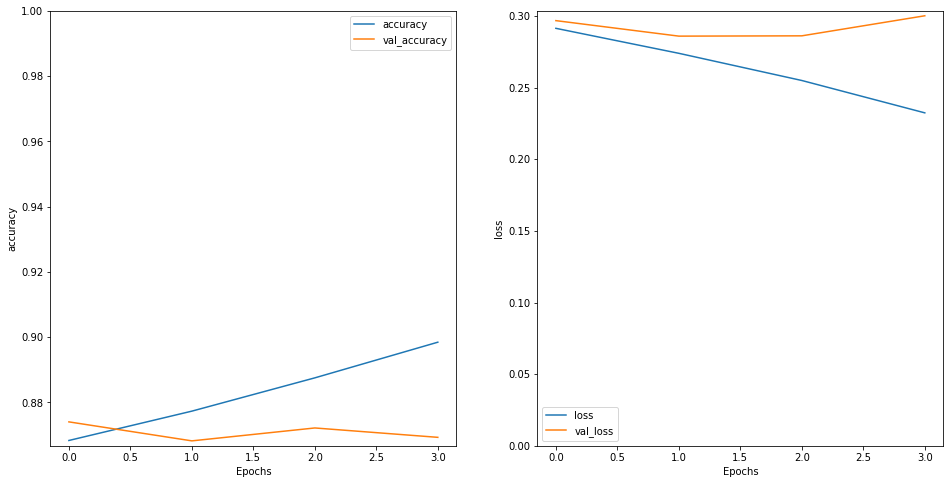

In [156]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

### BERT model

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

#### Load pre-trained model

In [ ]:
encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

#### Using pre-processing model to prepare data

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. If we want to mantain consistency with the pre-trained BERT model, we will use the same tensorflow Hub model for the preprocessing of the current pre-trained one used.

In [ ]:
bert_preprocess_model = hub.KerasLayer(preprocess)

We can now initialize the pre-trained model too, following the same keras layer construction on the Tensorflow hub.

In [ ]:
bert_encoder_model = hub.KerasLayer(encoder)

In [ ]:
def bert_model(preprocessing, encoder):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessing_layer = hub.KerasLayer(preprocessing)
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(encoder, trainable=True)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None)(net)
    return tf.keras.Model(text_input, net)

bert = bert_model(bert_preprocess_model, bert_encoder_model)
bert.summary()

In [ ]:
bert.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                         loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                         metrics=tf.metrics.BinaryAccuracy())

### Conclusion